In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts

In [2]:
#https://stackoverflow.com/questions/17211078/how-to-temporarily-modify-sys-path-in-python
#the above link is where i got this code.
#sys.path is restored to original state, after execution of the with statement
#importing sklearn from my directory INSTEAD of /public/apps/etc.etc. because mine is recent version
#apparently, this is called a context manager, visit above link for more explanation
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
with add_path('/home/hshadman/.local/lib/python3.7/site-packages'):
    sklearn = __import__('sklearn')

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

In [7]:
data = pd.read_csv("TCGA_PRAD_integrin_with_survival_info.csv",sep="\t")

In [10]:
for i in data.columns:
    print(i)

Sample_ID
ITGA8
ITGA9
ITGA1
ITGA2
ITGA3
ITGA4
ITGA5
ITGA6
ITGA7
ITGAX
ITGAV
ITGAL
ITGAM
ITGA2B
ITGAD
ITGAE
ITGBL1
ITGB1
ITGB3
ITGB5
ITGB4
ITGB7
ITGB6
ITGB8
ITGA10
ITGA11
ITGB2
_INTEGRATION
_PATIENT_left
_cohort
_primary_disease
_primary_site
additional_pharmaceutical_therapy
additional_radiation_therapy
age_at_initial_pathologic_diagnosis
bcr_followup_barcode
bcr_patient_barcode
bcr_sample_barcode
biochemical_recurrence
bone_scan_results
clinical_M
clinical_T
days_to_birth
days_to_bone_scan_performed
days_to_collection
days_to_death
days_to_diagnostic_computed_tomography_performed
days_to_diagnostic_mri_performed
days_to_first_biochemical_recurrence
days_to_initial_pathologic_diagnosis
days_to_last_followup
days_to_new_tumor_event_after_initial_treatment
days_to_psa
days_to_second_biochemical_recurrence
days_to_third_biochemical_recurrence
diagnostic_ct_abd_pelvis_performed
diagnostic_ct_abd_pelvis_result
diagnostic_mri_performed
diagnostic_mri_result
followup_case_report_form_submissi

/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


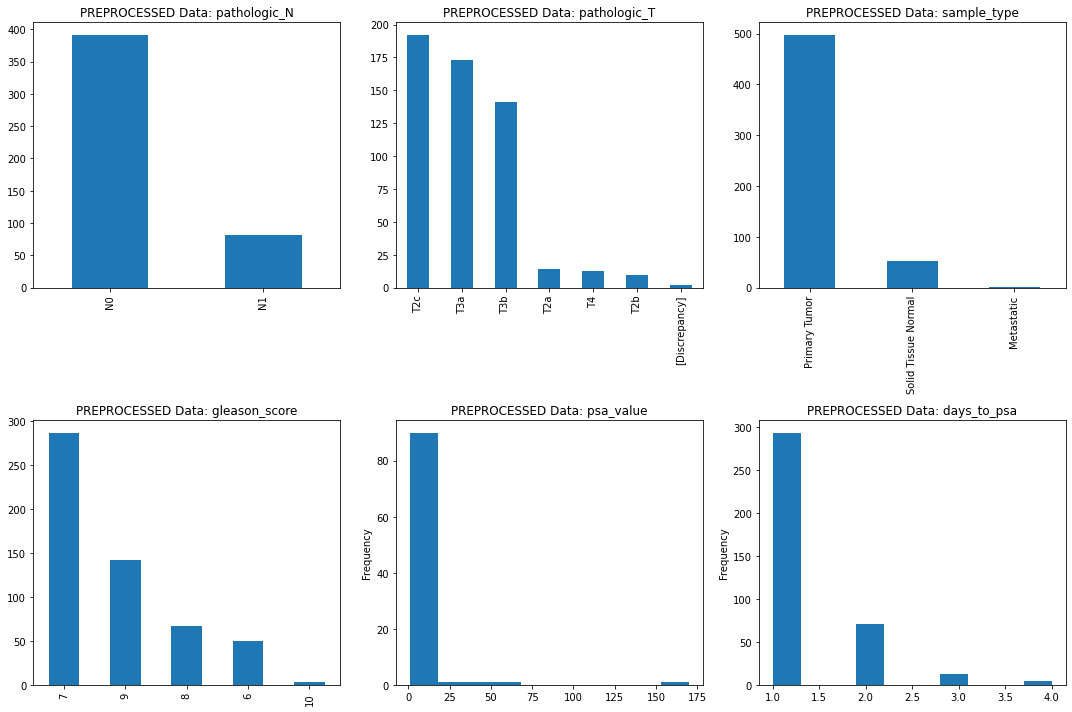

In [61]:
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(15,10))

data['pathologic_N'].value_counts().plot(kind='bar',ax=ax[0,0])
ax[0,0].set_title('PREPROCESSED Data: '+data['pathologic_N'].name)
data['pathologic_T'].value_counts().plot(kind='bar',ax=ax[0,1])
ax[0,1].set_title('PREPROCESSED Data: '+data['pathologic_T'].name)
data['sample_type'].value_counts().plot(kind='bar',ax=ax[0,2])
ax[0,2].set_title('PREPROCESSED Data: '+data['sample_type'].name)
data['gleason_score'].value_counts().plot(kind='bar',ax=ax[1,0])
ax[1,0].set_title('PREPROCESSED Data: '+data['gleason_score'].name)
data['psa_value'].value_counts().plot(kind='hist',ax=ax[1,1])
ax[1,1].set_title('PREPROCESSED Data: '+data['psa_value'].name)
data['days_to_psa'].value_counts().plot(kind='hist',ax=ax[1,2])
ax[1,2].set_title('PREPROCESSED Data: '+data['days_to_psa'].name)

plt.tight_layout()

In [62]:
integrins=np.array([])
for i in data.columns:
    if 'ITG' in i:
        integrins=np.append(integrins,i)

# only normal vs tumor

In [44]:
#integrin_normal=pd.concat([data[integrins],data['sample_type']],axis=1)
modified_data=data.copy()
normal_tissue_samples=modified_data[['patient_id','sample_type']][modified_data[['patient_id','sample_type']].sample_type=='Solid Tissue Normal'].patient_id.unique()
normal_available=[]
for patient in normal_tissue_samples:
    if patient in modified_data[['patient_id','sample_type']][modified_data[['patient_id','sample_type']].sample_type!='Solid Tissue Normal'].patient_id.unique():
        normal_available.append(patient)
normal_and_tumor=modified_data[modified_data['patient_id'].isin(normal_available)].copy()
normal_and_tumor=normal_and_tumor.drop(labels=normal_and_tumor[normal_and_tumor['sample_type']=='Metastatic'].index,axis=0).copy()


Text(0.5, 1.0, 'Only sample types involved')

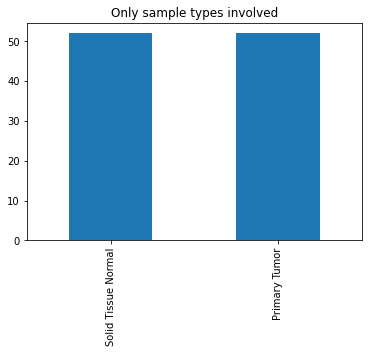

In [45]:
normal_and_tumor['sample_type'].value_counts().plot(kind='bar')
plt.title('Only sample types involved')

/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator


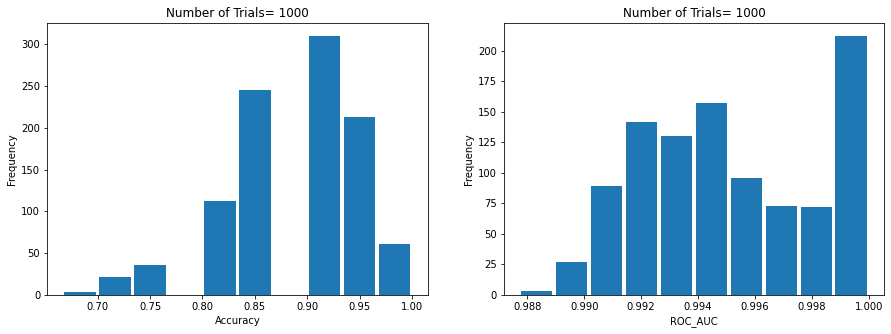

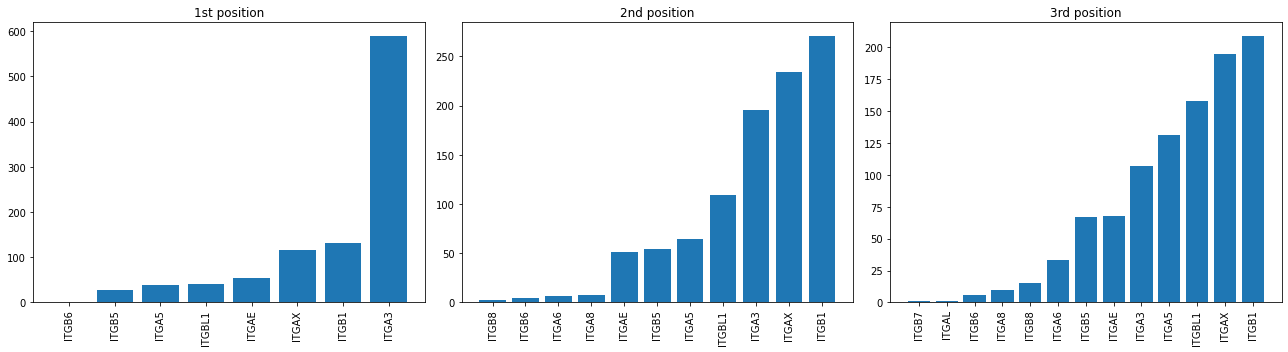

In [64]:
n=1000
accuracy=[]
roc_auc=[]
features_importance_ascendingorder=[]
for iteration in range(n+1):
    X=normal_and_tumor[integrins]
    y=normal_and_tumor['sample_type']
    #Scale data
    scaler = StandardScaler()
    scaler.fit(X) 
    X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20)
    classifier = LogisticRegression(random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
#    print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
    accuracy.append(accuracy_score(y_test,y_pred))
    roc_auc.append(roc_auc_score(y_train, classifier.predict_proba(X_train)[:,1]))
    feature_importance = abs(classifier.coef_[0])
    feature_importance = feature_importance / feature_importance.max()
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    features_importance_ascendingorder.append(X.columns[sorted_idx])
#below code draws a bar chart of feature importances
    #featfig = plt.figure(figsize=(10,10))
    #featax = featfig.add_subplot(1, 1, 1)
    #featax.barh(pos, feature_importance[sorted_idx], align='center')
    #featax.set_yticks(pos)
    #featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=12)
    #featax.set_xlabel('Relative Feature Importance',fontsize=15)
    #plt.tight_layout()
# accuracy histogram
#print(features_importance_ascendingorder)
#plt.grid(visible=True,which='major',axis='both')
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[0].hist(accuracy,rwidth=0.9)
ax[0].set_title('Number of Trials= '+str(n),)
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Frequency')

ax[1].hist(roc_auc,rwidth=0.9)
ax[1].set_title('Number of Trials= '+str(n),)
ax[1].set_xlabel('ROC_AUC')
ax[1].set_ylabel('Frequency')
first_important=[]
second_important=[]
third_important=[]
#features
import collections
for list_ in features_importance_ascendingorder:
    first_important.append(list_[-1])
    second_important.append(list_[-2])
    third_important.append(list_[-3])
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,5))
c=collections.Counter(first_important)
c={k: v for k, v in sorted(c.items(), key=lambda item: item[1])}
ax[0].bar(c.keys(),c.values())
ax[0].set_title('1st position')
c=collections.Counter(second_important)
c={k: v for k, v in sorted(c.items(), key=lambda item: item[1])}
ax[1].bar(c.keys(),c.values())
ax[1].set_title('2nd position')
c=collections.Counter(third_important)
c={k: v for k, v in sorted(c.items(), key=lambda item: item[1])}
ax[2].bar(c.keys(),c.values())
ax[2].set_title('3rd position')
plt.draw()

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
plt.tight_layout()


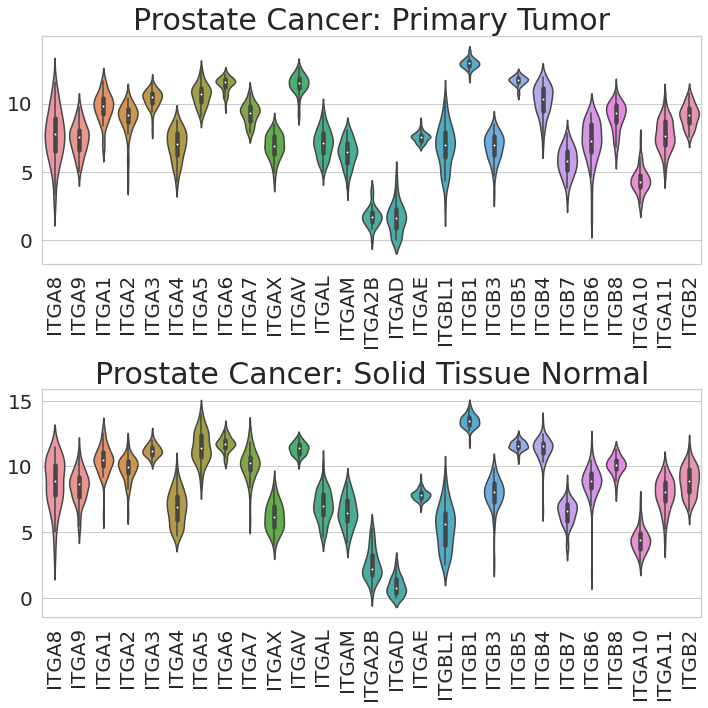

In [77]:
fig, axes = plt.subplots(nrows=len(normal_and_tumor['sample_type'].unique()),ncols=1,figsize=(10,10))
j=0
for sample_type in normal_and_tumor[normal_and_tumor['sample_type'].notna()].sample_type.unique():
    sns.set(style="whitegrid")
    ax=sns.violinplot(data=normal_and_tumor[normal_and_tumor.sample_type==sample_type][integrins],
                   scale='width',
                 ax=axes[j])
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=20)
    ax.tick_params(axis='y', labelsize=20)      
    #axes[j].set_ylim(-4,16)
    axes[j].set_title('Prostate Cancer: '+str(sample_type),fontsize=30)
    j+=1
    
plt.tight_layout()


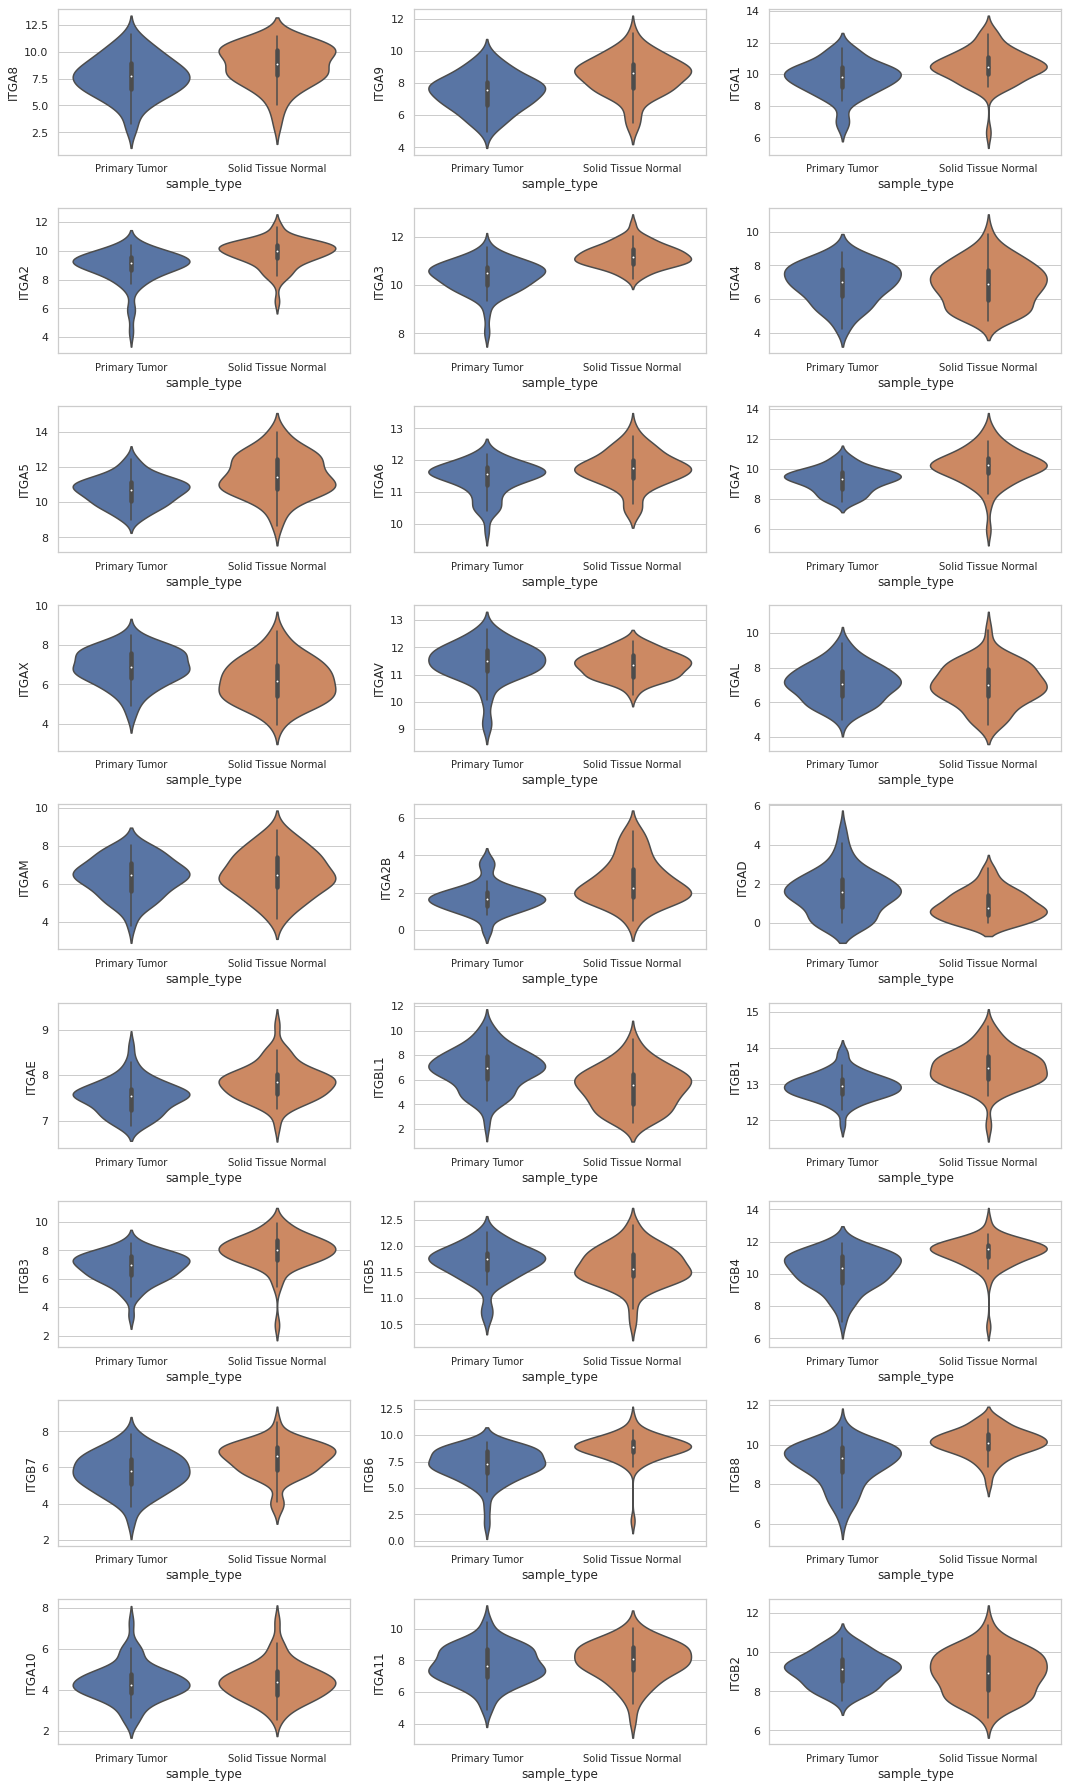

In [97]:
fig, axes = plt.subplots(nrows=int(len(integrins)/3),ncols=3,figsize=(15,25))
j=0
i=0
k=0
for single_integrin in normal_and_tumor[integrins].columns:
    sns.set(style="whitegrid")
    ax=sns.violinplot(x=normal_and_tumor['sample_type'],y=normal_and_tumor[single_integrin],
                   scale='width',
                 ax=axes[i,j])
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=10)
    k+=1
    if k%3==0:
        i+=1
        j=0
    else:
        j+=1
plt.tight_layout()

In [88]:
9%3

0